<a href="https://colab.research.google.com/github/ORUNSOLU/Practice/blob/main/FaceMaskPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the Images

DpHi FaceMask Prediction challenge

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo', dest_path='content/face_mask_detection.zip', unzip=True)

Unzipping...Done.


Loading the Libraries

In [3]:
import pandas as pd                                     
import numpy as np                                    
import tensorflow as tf                                 
import os                                              
import cv2                                             
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Loading and Preparing data

In [4]:
train_dir = 'content/face_mask_detection/train/'
test_dir = 'content/face_mask_detection/test/'

train_images = pd.read_csv('content/face_mask_detection/Training_set_face_mask.csv')
test_images = pd.read_csv('content/face_mask_detection/Testing_set_face_mask.csv')


In [5]:
train_images.head()

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [6]:
train_file_paths = [('/content/content/face_mask_detection/train/' + fname) for fname in train_images['filename']]
test_file_paths = [('/content/content/face_mask_detection/test/' + fname) for fname in test_images['filename']]

print(train_file_paths[:10])
print(test_file_paths[:10])

['/content/content/face_mask_detection/train/Image_1.jpg', '/content/content/face_mask_detection/train/Image_2.jpg', '/content/content/face_mask_detection/train/Image_3.jpg', '/content/content/face_mask_detection/train/Image_4.jpg', '/content/content/face_mask_detection/train/Image_5.jpg', '/content/content/face_mask_detection/train/Image_6.jpg', '/content/content/face_mask_detection/train/Image_7.jpg', '/content/content/face_mask_detection/train/Image_8.jpg', '/content/content/face_mask_detection/train/Image_9.jpg', '/content/content/face_mask_detection/train/Image_10.jpg']
['/content/content/face_mask_detection/test/Image_1.jpg', '/content/content/face_mask_detection/test/Image_2.jpg', '/content/content/face_mask_detection/test/Image_3.jpg', '/content/content/face_mask_detection/test/Image_4.jpg', '/content/content/face_mask_detection/test/Image_5.jpg', '/content/content/face_mask_detection/test/Image_6.jpg', '/content/content/face_mask_detection/test/Image_7.jpg', '/content/content/

In [7]:
train_images['filepaths'] = train_file_paths
test_images['filepaths'] = test_file_paths

train_images.head()

,filename,label,filepaths
0,Image_1.jpg,without_mask,/content/content/face_mask_detection/train/Ima...
1,Image_2.jpg,without_mask,/content/content/face_mask_detection/train/Ima...
2,Image_3.jpg,without_mask,/content/content/face_mask_detection/train/Ima...
3,Image_4.jpg,without_mask,/content/content/face_mask_detection/train/Ima...
4,Image_5.jpg,without_mask,/content/content/face_mask_detection/train/Ima...


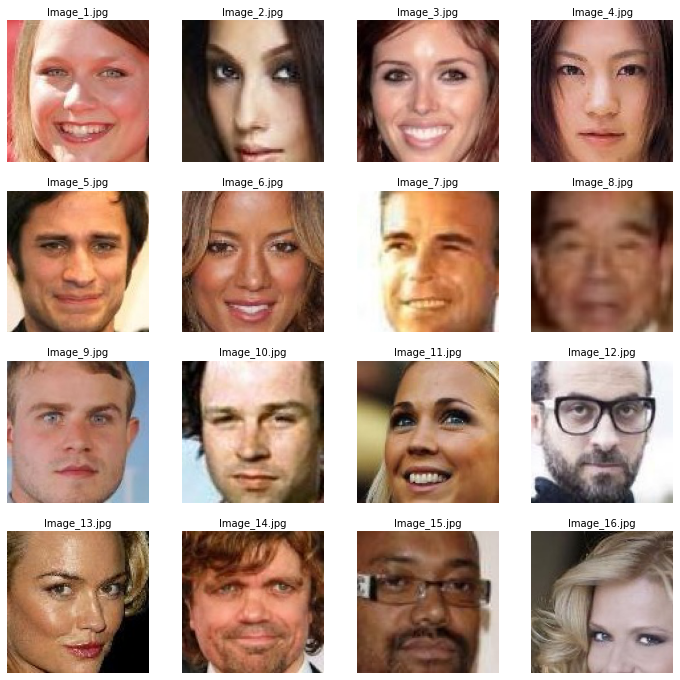

In [8]:
import matplotlib.image as mpimg

nrows = 4
ncols = 4
plt.figure(figsize=(12, 12))

for i in range(0, 16):
  # image_name = train_images['filepaths'].str.split('/', 5)[5]
  image_name = train_images['filename'][i]
  sp = plt.subplot(4, 4, i+1)
  sp.axis('off')
  image = mpimg.imread(train_images['filepaths'][i])
  sp.set_title(image_name, fontsize=10)
  plt.imshow(image, cmap='gray')

plt.show()

Data Pre-processing

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255.0, zoom_range=0.05, rotation_range=20, horizontal_flip=True,
                                   fill_mode='nearest', validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_images, directory=train_dir, x_col='filename', shuffle=True,
                                  y_col='label', target_size=(224, 224), batch_size=32, class_mode='binary', subset='training')
valid_generator = train_datagen.flow_from_dataframe(train_images, directory=train_dir, x_col='filename', shuffle=True,
                                                    y_col='label', target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation')

test_generator = test_datagen.flow_from_dataframe(test_images, directory=test_dir,
                                                  x_col='filename', target_size=(224, 224), batch_size=1, shuffle=False, class_mode=None)



Found 9012 validated image filenames belonging to 2 classes.
Found 2252 validated image filenames belonging to 2 classes.
Found 1536 validated image filenames.


Building Model

In [10]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='SAME',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [11]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=30, validation_data=valid_generator)

Epoch 1/30
282/282 [==============================] - 892s 3s/step - loss: 1.9262 - accuracy: 0.7702 - val_loss: 0.3173 - val_accuracy: 0.9387
Epoch 2/30
282/282 [==============================] - 900s 3s/step - loss: 0.1733 - accuracy: 0.9386 - val_loss: 0.5118 - val_accuracy: 0.8006
Epoch 3/30
282/282 [==============================] - 889s 3s/step - loss: 0.1547 - accuracy: 0.9384 - val_loss: 0.1226 - val_accuracy: 0.9702
Epoch 4/30
282/282 [==============================] - 883s 3s/step - loss: 0.1322 - accuracy: 0.9496 - val_loss: 0.1322 - val_accuracy: 0.9663
Epoch 5/30
282/282 [==============================] - 901s 3s/step - loss: 0.1156 - accuracy: 0.9580 - val_loss: 0.2958 - val_accuracy: 0.9081
Epoch 6/30
282/282 [==============================] - 884s 3s/step - loss: 0.1118 - accuracy: 0.9601 - val_loss: 0.1283 - val_accuracy: 0.9596
Epoch 7/30
282/282 [==============================] - 886s 3s/step - loss: 0.1036 - accuracy: 0.9638 - val_loss: 0.1653 - val_accuracy: 0.9387

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

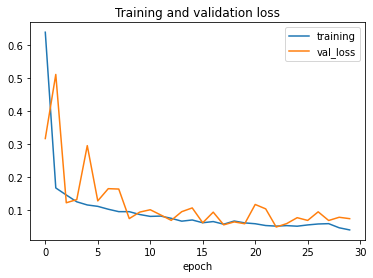

In [13]:
#view loss for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'val_loss'])
plt.title('Training and validation loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

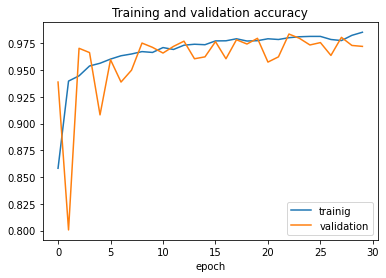

In [14]:
#view accuracy for both Training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['trainig','validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

Validate Model

In [15]:
val_loss, val_acc = model.evaluate(valid_generator)
print('val loss: {}, val acc: {}'.format(val_loss, val_acc))


71/71 [==============================] - 70s 976ms/step - loss: 0.0681 - accuracy: 0.9751
val loss: 0.06807778030633926, val acc: 0.9751332402229309


Predict The Output For Testing Dataset

In [17]:
predicted = model.predict_classes(test_generator)
predicted[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

Save results for assesment

In [19]:
test_images['label'] = predicted
test_images.head()

,filename,label,filepaths
0,Image_1.jpg,1,/content/content/face_mask_detection/test/Imag...
1,Image_2.jpg,0,/content/content/face_mask_detection/test/Imag...
2,Image_3.jpg,1,/content/content/face_mask_detection/test/Imag...
3,Image_4.jpg,1,/content/content/face_mask_detection/test/Imag...
4,Image_5.jpg,0,/content/content/face_mask_detection/test/Imag...


In [21]:
# To download the csv file locally
from google.colab import files 

test_images.to_csv('predictions.csv')
files.download('predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The output is in INT format, where 1 = 'without_mask' and 0 = 'with_mask', to convert them to LABELs. Just uncomment the code below to do the Job.

In [ ]:
#create the function for conversion
# def rectify(x):
#     return 'without_mask' if x==1 else 'with_mask'

#code to change the
# pred = []
# pred = test_images['prediction'].map(rectify)
# test_images['prediction'] = pred
# test_images.to_csv('predictions.csv')
